# What is stixdcpy
stixdcpy is a python package that facilitates access and analysis of STIX data. It provides APIs to query and download data from STIX data center (https://datacenter.stix.i4ds.net/) and s a set of tools for visualizing data and performing common analysis tasks.  With stixdcpy, users can query and download the following types of data from STIX data center:

- Quick-look light curves
- Housekeeping data
- Science data
- Energy calibration data
- Auxilary data
- STIX solar flare list



# Installation
```sh 
pip install stixdcpy
```
stixdcpy can be also installed from the stixdcpy github repository:
```sh 
pip install git+https://github.com/i4ds/stixdcpy.git
```

# Tutorial and documentation

- [Tutorial on Google Colab](https://colab.research.google.com/drive/17fQfbWjL0s0TpblbPL1Ysy_zFXj40FBf?usp=sharing)
- [Documentation](https://drhlxiao.github.io/stixdcpy/)

# Reporting Issues and Contributing

Open an issue on the GitHub repo to report a problem. Pull requests welcome.
Github repo: https://github.com/i4ds/stixdcpy



# Install dependencies 

In [1]:
#Install stixdcpy from pypi
#!pip install stixdcpy
# Or install from stixdcpy github repository

#!pip install git+https://github.com/i4ds/stixdcpy.git
#!pip install numpy matplotlib pandas astropy joblib simplejson

In [2]:
import numpy as np
import pandas as pd

from pprint import pprint
from datetime import timedelta
from matplotlib import pyplot as plt
from astropy.table import QTable
from stixdcpy.quicklook import LightCurves
from stixdcpy.energylut import EnergyLUT
from stixdcpy import auxiliary as aux
from stixdcpy.net import FitsQuery as fq
from stixdcpy.net import JSONRequest as jreq
from stixdcpy import instrument as inst
from stixdcpy.science import ScienceL1, Spectrogram, spec_fits_crop, spec_fits_concatenate, fits_time_to_datetime
from stixdcpy.housekeeping import Housekeeping
from astropy.io import fits
from stixdcpy import detector_view as dv
from stixdcpy import spectrogram  as cspec
#from google.colab import data_table
#data_table.enable_dataframe_formatter()
%matplotlib notebook

# Request Quick-look  data from STIX data center 

Let's download some light curves from STIX data center

In [3]:
lc = LightCurves.from_sdc(start_utc='2022-08-30T05:00:00', end_utc='2022-08-30T10:00:00', ltc=True)


where: 
* start_utc -  start time (onboard time); 
* end_utc - end time ; 
* ltc - an optional argument.  Perform light time correction to light curves if it is True

It returns a data object



Preview the QL lightcurves

<IPython.core.display.Javascript object>


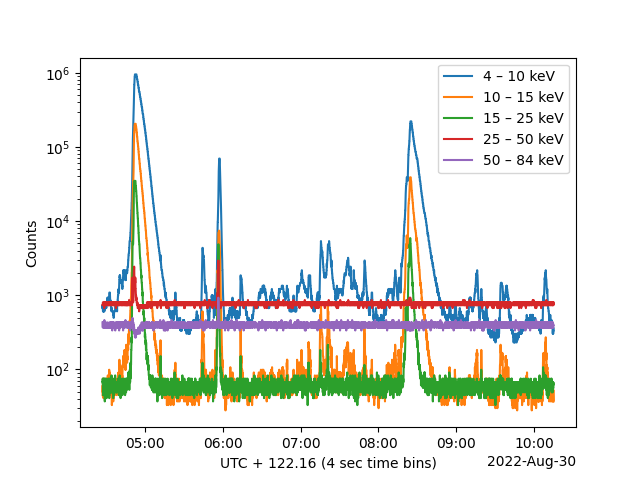

<AxesSubplot:xlabel='UTC + 122.16 (4 sec time bins)', ylabel='Counts'>

In [4]:
lc.peek()

Access the data:

In [5]:
lc.data.keys()


dict_keys(['rcr', 'triggers', 'energy_bins', 'num', 'start_unix', 'start_utc', 'end_unix', 'end_utc', 'DELTA_LIGHT_TIME', 'SOLO_EARTH_LIGHT_TIME', 'IS_LIGHT_TIME_CORRECTED', 'delta_time', 'counts'])

In [6]:
#pprint(lc.data['counts'])

<IPython.core.display.Javascript object>


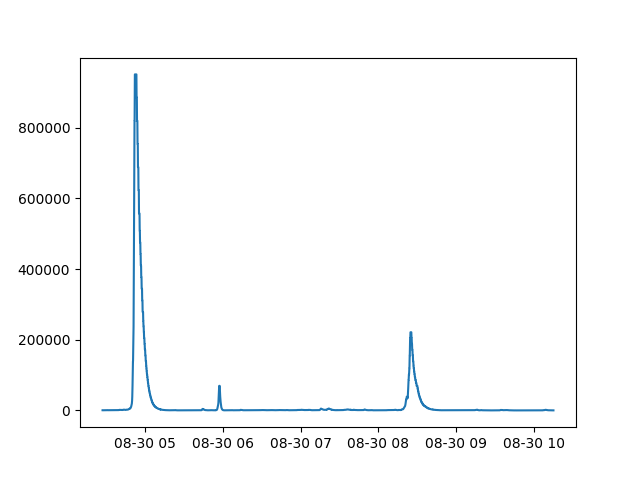

In [7]:
fig=plt.figure()
plt.plot(lc.time, lc.counts[0,:])

# Housekeep data

Fetching housekeeping data from STIX data center:



In [8]:
hk=Housekeeping.from_sdc(start_utc='2021-09-06T12:00:00', end_utc='2021-09-06T14:00:00')
pprint(hk.param_names)


{'NIX00020': 'SID',
 'NIX00072': 'Med value of trig acc',
 'NIX00073': 'Max value of trig acc',
 'NIX00076': 'Attenuator motions',
 'NIX00078': 'HK_ASP_PHOTOA0_V',
 'NIX00079': 'HK_ASP_PHOTOA1_V',
 'NIX00080': 'HK_ASP_PHOTOB0_V',
 'NIX00081': 'HK_ASP_PHOTOB1_V',
 'NIX00085': 'FDIR function status',
 'NIX00094': 'Attenuator currents',
 'NIXD0001': 'SW Version Number',
 'NIXD0002': 'CPU load',
 'NIXD0003': 'Archive Memory usage',
 'NIXD0004': 'IDPU identifier',
 'NIXD0005': 'Active SPW link',
 'NIXD0021': 'SW running',
 'NIXD0022': 'Instrument number',
 'NIXD0023': 'Instrument mode',
 'NIXD0024': 'HK_PSU_TEMP_T',
 'NIXD0025': 'HK_DPU_PCB_T',
 'NIXD0026': 'HK_DPU_FPGA_T',
 'NIXD0027': 'HK_DPU_3V3_C',
 'NIXD0028': 'HK_DPU_2V5_C',
 'NIXD0029': 'HK_DPU_1V5_C',
 'NIXD0030': 'HK_DPU_SPW_C',
 'NIXD0031': 'HK_DPU_SPW0_V',
 'NIXD0032': 'HK_DPU_SPW1_V',
 'NIXD0035': 'HK_DPU_1V5_V',
 'NIXD0036': 'HK_REF_2V5_V',
 'NIXD0037': 'HK_DPU_2V9_V',
 'NIXD0038': 'HK_ASP_REF_2V5A_V',
 'NIXD0039': 'HK_ASP_REF_

Plot housekeeping data time series:

<IPython.core.display.Javascript object>


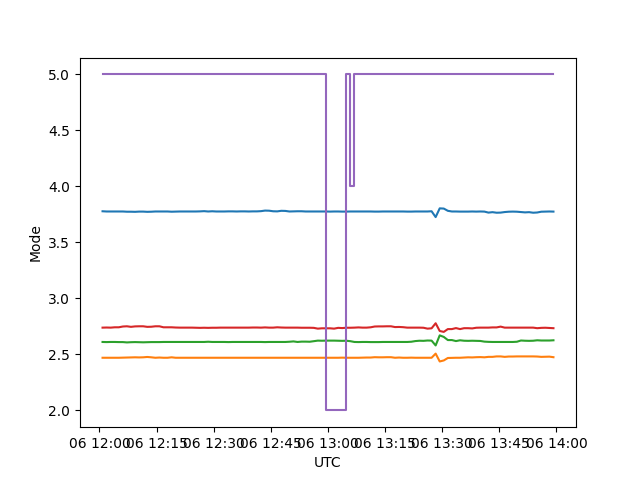

<AxesSubplot:xlabel='UTC', ylabel='Value'>

In [9]:
hk.plot('NIX00078,NIX00079,NIX00080,NIX00081')


You need to provide the names of parameters to be plotted.

One could also plot time series of parameters using plt

In [10]:
plt.step( hk.data['datetime'], hk.data['raw_values']['NIXD0023'])
plt.xlabel('UTC')
plt.ylabel('Mode')

Text(0, 0.5, 'Mode')

# Calibration data

Request calibration data from STIX data center

In [11]:
elut=EnergyLUT.request('2021-09-03T00:00:00')

Print information on the onboard elut and the calibration run peformed closest to the specified time:

In [12]:
elut.info()


{'calibration_run': {'duration': 86400,
                     'obs_begin': '2021-09-02T12:56:17.958',
                     'run_id': 1353},
 'onboard_elut': {'upload_time_range': ['2021-06-25T14:54:14.456',
                                        '2021-06-25T14:55:49.456']}}


Print energy calibration factors 

In [13]:
elut.data

{'data': {'onboard': {'slopes': [2.287,
    2.2879,
    2.2879,
    2.2696,
    2.2834,
    2.2615,
    2.3119,
    2.2827,
    2.3123,
    2.2925,
    2.2857,
    2.2703,
    2.3149,
    2.2891,
    2.2962,
    2.3151,
    2.3197,
    2.3149,
    2.2961,
    2.3058,
    2.3196,
    2.3029,
    2.2999,
    2.2901,
    2.3259,
    2.3232,
    2.3121,
    2.3316,
    2.3389,
    2.3229,
    2.3351,
    2.328,
    2.3306,
    2.3544,
    2.3318,
    2.3351,
    2.322,
    2.3287,
    2.3264,
    2.3121,
    2.3403,
    2.3121,
    2.3232,
    2.3174,
    2.3411,
    2.349,
    2.3351,
    2.3107,
    2.2761,
    2.285,
    2.2686,
    2.3035,
    2.3021,
    2.2891,
    2.2728,
    2.2902,
    2.2926,
    2.2962,
    2.2921,
    2.2912,
    2.2906,
    2.2572,
    2.2672,
    2.2849,
    2.2817,
    2.272,
    2.2904,
    2.2972,
    2.2999,
    2.2751,
    2.2943,
    2.2686,
    2.3161,
    2.2895,
    2.3112,
    2.3,
    2.3141,
    2.2915,
    2.2659,
    2.3187,
    2.3247,
    2.30

Print the real energy range of bins of a pixel

In [14]:
lut=elut.get_pixel_true_ebins(pixel=34)

pd.DataFrame(lut)

,0,1
0,0.007,3.998
1,3.998,4.996
2,4.996,5.993
3,5.993,6.991
4,6.991,7.989
5,7.989,8.987
6,8.987,9.984
7,9.984,10.982
8,10.982,11.980
9,11.980,12.978


# S/C Ephemeris 

Fetch s/c ephemeris data from STIX data center: 

In [15]:
emph=aux.Ephemeris.from_sdc(start_utc='2022-01-01T00:00:00', end_utc='2022-03-31T01:00:00', steps=100)

Preview the data

<IPython.core.display.Javascript object>


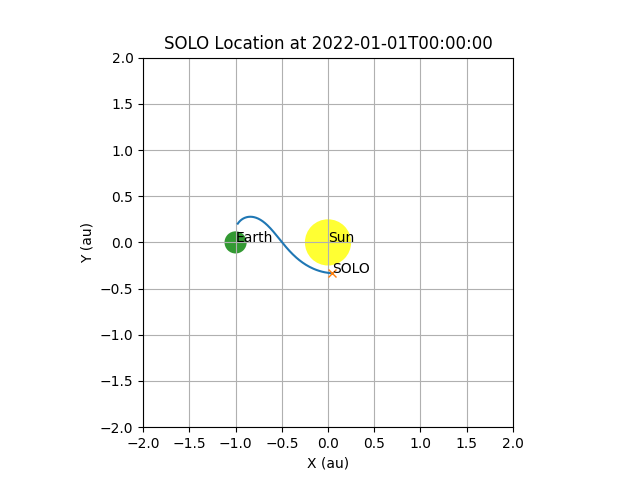

<AxesSubplot:title={'center':'SOLO Location at 2022-01-01T00:00:00'}, xlabel='X (au)', ylabel='Y (au)'>

In [16]:
emph.peek()

In [17]:
pprint(emph.data['orbit'])

{'earth_solo_r': [0.2044279618744277,
                  0.20705753787751827,
                  0.2096716090915357,
                  0.2122699072095594,
                  0.21485198553079826,
                  0.2174176384200076,
                  0.21996642799585492,
                  0.22249809998604916,
                  0.22501240634791508,
                  0.22750893465897865,
                  0.229987512849541,
                  0.23244775023512823,
                  0.2348894379665569,
                  0.23731237606940941,
                  0.2397162080176243,
                  0.24210080964895983,
                  0.24446584650570002,
                  0.24681115875064802,
                  0.2491365943429191,
                  0.2514418504326433,
                  0.25372684663502026,
                  0.2559913008207538,
                  0.25823509806763806,
                  0.2604581311300286,
                  0.2626601492698014,
                  0.26484111523993353,

# STIX pointing

<IPython.core.display.Javascript object>


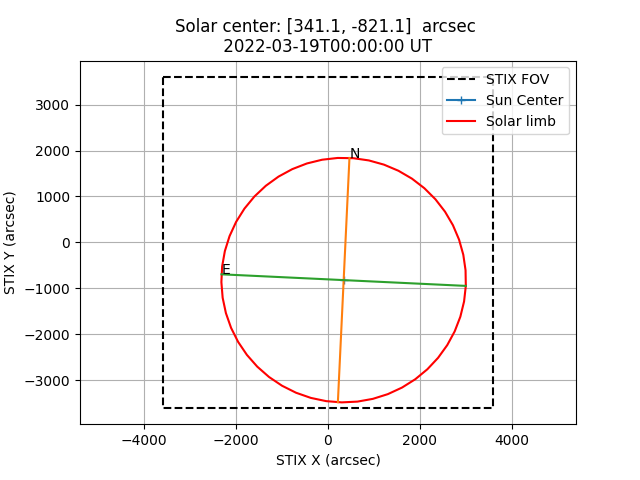

<AxesSubplot:title={'center':'Solar center: [341.1, -821.1]  arcsec \n 2022-03-19T00:00:00 UT '}, xlabel='STIX X (arcsec)', ylabel='STIX Y (arcsec)'>

In [18]:
fov=aux.Pointing.from_sdc('2022-03-19T00:00:00')
fov.peek()


The web tool at the link https://datacenter.stix.i4ds.net/view/ancillary provides more detailed information of STIX pointing

In [19]:
#Let's plot the data
pprint(fov.data)

{'cmat': [[0.9999907090312987, 0.001840261871741647, -0.003898113303186068],
          [-0.0016535916865896144, 0.998876476466614, 0.047360852992488545],
          [0.0039808900531294045, -0.047353967076534165, 0.9988702389782664]],
 'cmat_inv': [[0.9999907090312982,
               -0.0016535916865894973,
               0.003980890053129371],
              [0.001840261871741764, 0.9988764764666137, -0.047353967076534186],
              [-0.0038981133031860955,
               0.04736085299248853,
               0.9988702389782669]],
 'fov': {'x': [-3600, 3600, 3600, -3600, -3600],
         'y': [3600, 3600, -3600, -3600, 3600]},
 'frame': 'STIX_ILS',
 'limb': {'x': [3000.8128080683136,
                2995.1035726826553,
                2945.820399881108,
                2853.771643528216,
                2720.467216223356,
                2548.094004535557,
                2339.4802273563573,
                2098.049284960591,
                1827.7638160812212,
                1533.06

# Solar flare light time difference and viewing angle calculator

This tool allows calculation of the light time difference between a flare and observers at earth or solar orbiter, as well as the viewing angles. 

In [20]:
flare_aux=jreq.request_flare_light_time_and_angle(utc='2022-03-01T00:00:00', flare_x=100, flare_y=1000, observer='stix')


pprint(flare_aux)

{'dt_flare': 206.81775484749522,
 'dt_sun_center': 206.73656587739646,
 'earth_flare_solo_deg': 9.41511379278742,
 'earth_sun_lt': 494.3731333687276,
 'flare_earth_lt': 492.60127454105276,
 'flare_norm_earth_deg': 40.31041559179079,
 'flare_norm_solo_deg': 37.150886309249145,
 'flare_solo_lt': 285.78351969355754,
 'flare_solo_r': 0.5727069738621823,
 'flare_utc': '2022-03-01T00:00:00',
 'mk': 'solo_ANC_soc-flown-mk_V107_20230209_001.tm',
 'observer': 'stix',
 'sun_solo_lt': 287.63656749133116}


where:        

* utc -    observation time
* flare_x -  flare helio-projective longitude in units of arcsec as seen by the observer 
* flare_y -  flare helio-projective latitude in units of arcsec 
* observer: It can be either "earth" or "stix" . The default value is "earth". 

A data object is returnned


The tool is available at the link
https://datacenter.stix.i4ds.net/view/ancillary


# Access and preview science data

## level-1 science data


Let's download a level-1 science data file from STIX data center

In [21]:
l1_obj=ScienceL1.from_sdc(request_id=2208270251)

Here **2112240046** is the requests ID (also called unique id), which can  can be found on the science data web page https://datacenter.stix.i4ds.net/view/list/bsd.   
**ltc** is an optional argument. Light time correction will be performed if ltc = True. 
**l1_obj** is a data object 

Access the FITS Header Data Unit List attached to the data object:

In [22]:
hdul=l1_obj.hdul
hdul.info()

Filename: /home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-xray-cpd-2208270251_20220827T040657-20220827T040815_177461_V01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  CONTROL       1 BinTableHDU     31   1R x 8C   ['J', 'J', 'J', '3B', '3B', 'D', 'K', '32B']   
  2  DATA          1 BinTableHDU     45   78R x 12C   ['D', 'D', 'B', '144B', '32B', 'B', 'B', '16K', '16D', '12288D', '12288D', 'K']   
  3  ENERGIES      1 BinTableHDU     19   32R x 3C   ['K', 'D', 'D']   


Note that FITS hdul is only one of the data attributes.  

Let's print the hdul header

In [23]:
hdul['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'SOLO/STIX'          / Telescope/Sensor name                          
INSTRUME= 'STIX    '           / Instrument name                                
OBSRVTRY= 'Solar Orbiter'      / Satellite name                                 
FILENAME= 'solo_L1A_stix-sci-xray-cpd-2208270251_20220827T040657-20220827T0408&'
CONTINUE  '15_177461_V01.fits&'                                                 
CONTINUE  '' / FITS filename                                                    
DATE    = '2022-11-19T21:26:06.136' / FITS file creation date in UTC            
OBT_BEG = '0714888282:19651'                                                    
OBT_END = '0714888360:19642'

Preview science data 

<IPython.core.display.Javascript object>


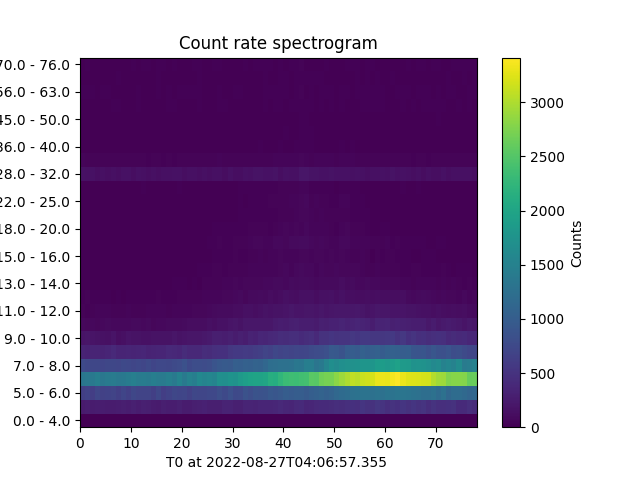

<IPython.core.display.Javascript object>


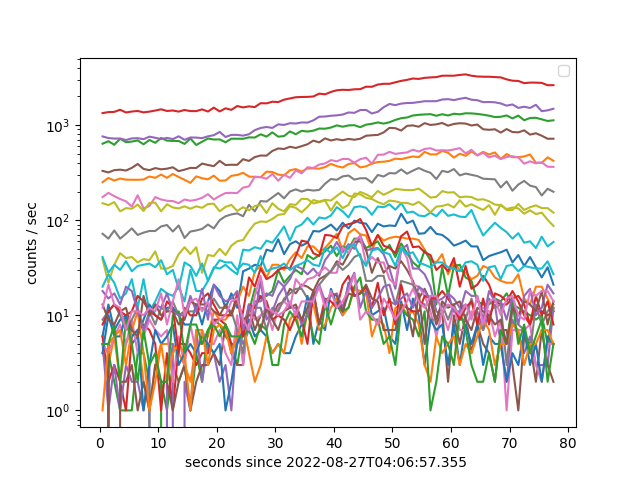

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<IPython.core.display.Javascript object>


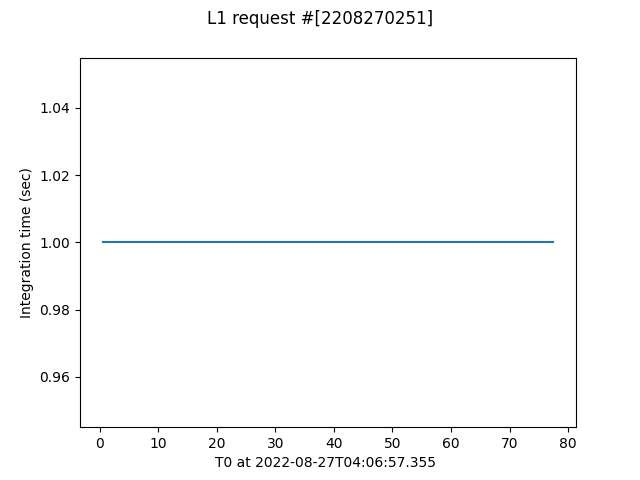

(<AxesSubplot:title={'center':'Count rate spectrogram'}, xlabel='T0 at 2022-08-27T04:06:57.355 ', ylabel='Energy range(keV'>,
 <AxesSubplot:xlabel='seconds since 2022-08-27T04:06:57.355 ', ylabel='counts / sec'>,
 None,
 <AxesSubplot:xlabel='T0 at 2022-08-27T04:06:57.355 ', ylabel='Integration time (sec)'>)

In [24]:
l1_obj.peek('spg,lc, spec,tbin, qllc')


Peform dead time correction to the data

In [25]:
corrected_data=l1_obj.correct_dead_time()

Print the array dimensions

In [26]:
corrected_data.keys()
for key, value in corrected_data.items():
    print(key, value.shape)

corrected_rates (78, 32, 12, 32)
count_rate (78, 32, 12, 32)
photons_in (78, 16)
live_ratio (78, 32)
live_error (78, 32)


Plot the live ratios of detectors: 

<IPython.core.display.Javascript object>


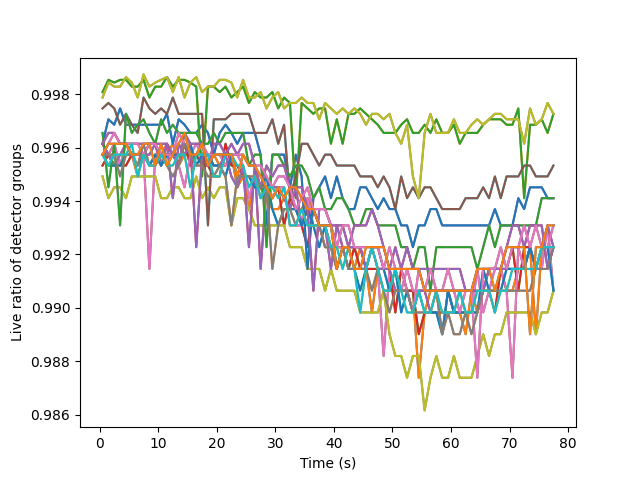

Text(0, 0.5, 'Live ratio of detector groups')

In [27]:
plt.figure()
plt.plot(l1_obj.time, corrected_data['live_ratio'])
plt.xlabel('Time (s)')
plt.ylabel('Live ratio of detector groups')

Plot pixel and energy integerated corrected count rate:

<IPython.core.display.Javascript object>


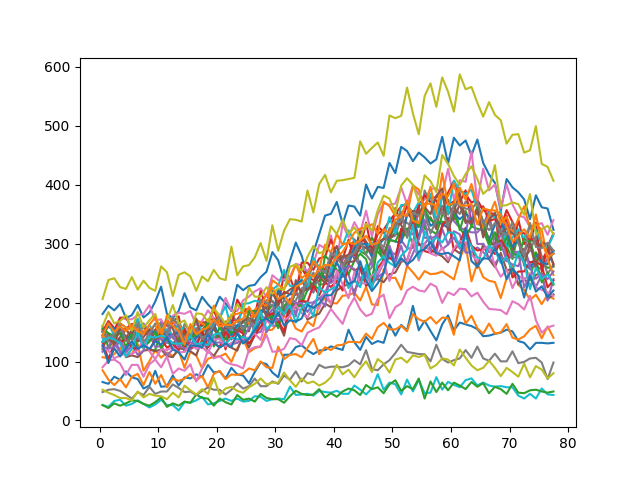

In [28]:
plt.figure()
plt.plot(l1_obj.time, np.sum(corrected_data['corrected_rates'], axis=(2,3) ))


Visualize counts with the module DetectorView

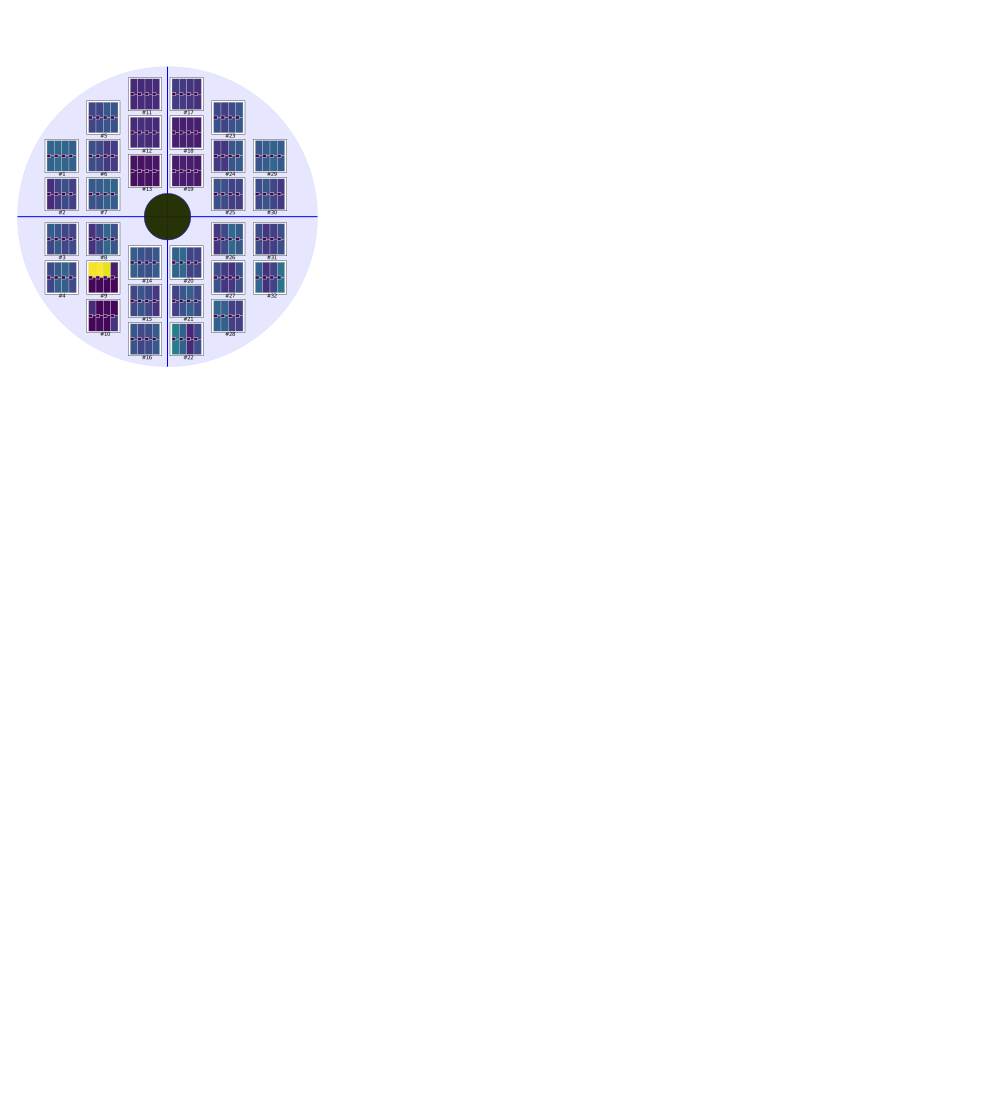

In [29]:
pixel_counts = l1_obj.pixel_total_counts
det_view = dv.DetectorView(pixel_counts)
det_view.display()

In [30]:
l1_obj.ebins_high

array([  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
        15.,  16.,  18.,  20.,  22.,  25.,  28.,  32.,  36.,  40.,  45.,
        50.,  56.,  63.,  70.,  76.,  84., 100., 120., 150.,  inf])

In [31]:
#print(l1_obj.url)
#link to science browser 

## Download and plot spectrograms

Let's fetch a spectrogram data file from STIX data center

In [32]:
request_id=	2210223333
l4d=Spectrogram.from_sdc(request_id=request_id)


Filename: /home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-xray-spec-2210223333_20221022T230507-20221023T051017_178002_V01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  CONTROL       1 BinTableHDU     39   1R x 11C   ['J', 'J', 'J', '3B', '3B', 'D', 'J', '12B', '32B', 'K', '32B']   
  2  DATA          1 BinTableHDU     33   7015R x 8C   ['D', 'D', 'B', 'K', 'D', '32D', '32D', 'K']   
  3  ENERGIES      1 BinTableHDU     19   32R x 3C   ['K', 'D', 'D']   


<IPython.core.display.Javascript object>


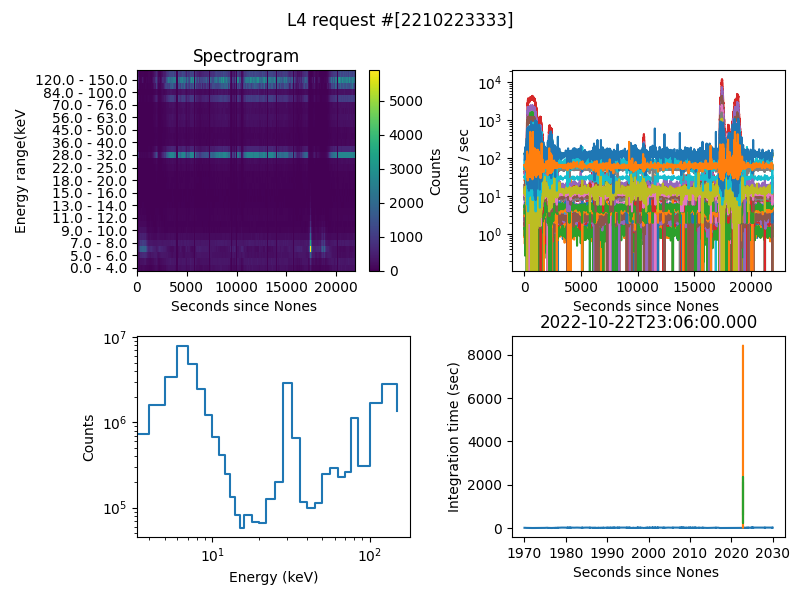

(<Figure size 800x600 with 5 Axes>,
 ((<AxesSubplot:title={'center':'Spectrogram'}, xlabel='Seconds since Nones ', ylabel='Energy range(keV'>,
   <AxesSubplot:xlabel='Seconds since Nones ', ylabel='Counts / sec'>),
  (<AxesSubplot:xlabel='Energy (keV)', ylabel='Counts'>,
   <AxesSubplot:xlabel='Seconds since Nones ', ylabel='Integration time (sec)'>)))

In [33]:
l4d.hdul.info()
l4d.peek()

## Crop or combine spectrograms

To select a shorter time interval from a long-duration spectrogram, or to combine two spectrograms into a single FITS file

In [34]:
plt.plot(l4d.datetime, np.sum(l4d.counts[:,4:10],axis=1))
plt.title(l4d.T0_utc)

Text(0.5, 1.0, '2022-10-22T23:05:07.637')

In [35]:
tstart = '2022-10-22T23:06:00'
tend = '2022-10-22T23:15:00'

In [36]:
cropped_file = spec_fits_crop(l4d.filename, tstart, tend)

A new file containing the cropped spectrogram has been created. It can be accessed at its location:

In [37]:
cropped_file

'/home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-xray-spec-2210223333_20221022T230507-20221023T051017_178002_V01_230600_231500.fits'

In [38]:
cropped_spec = Spectrogram(cropped_file, None)
plt.plot(cropped_spec.datetime, np.sum(cropped_spec.counts[:,4:10],axis=1))
plt.title(cropped_spec.T0_utc)

Text(0.5, 1.0, '2022-10-22T23:06:00.000')

Similarly, two spectrogram files can be combined, and simultaneously cropped to a particular time range if desired.

In [39]:
spec_res=fq.query('2022-04-19T20:00:00', '2022-04-19T23:00:00', product_type='xray-spec')
file_locations = spec_res.fetch()

In [40]:
tstart='2022-04-19T20:05:00'
combined_file = spec_fits_concatenate(file_locations[0], file_locations[1], tstart=tstart)

/home/xiaohl/.local/lib/python3.10/site-packages/stixdcpy/science.py:923: UserWarning: Gap of 0.038s between spectrogram files /home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-spectrogram-2204199624_20220419T142011-20220419T202506_056955_V01.fits and /home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-spectrogram-2204198941_20220419T202506-20220420T023014_056956_V01.fits
  warnings.warn(


A new file containing the combined spectrogram has been created. It can be accessed at its location:

In [41]:
combined_file

'/home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-spectrogram-2204199624_20220419T142011-20220419T202506_056955_V01_200500_023014.fits'

In [42]:
with fits.open(combined_file) as f:
    primary, _, data, _ = f
    spectimes = fits_time_to_datetime(primary.header, data.data)
    plotdata = np.sum(data.data.counts[:,4:10],axis=1)

In [56]:
#import matplotlib.dates as mdates
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
#plt.plot(spectimes.datetime,plotdata)
#plt.gcf().autofmt_xdate()
#plt.title(spectimes[0].isot)

In [59]:
spec = cspec.Spectrogram.from_sdc('2022-12-23T20:14:00', '2022-12-24T01:41:00')

<IPython.core.display.Javascript object>


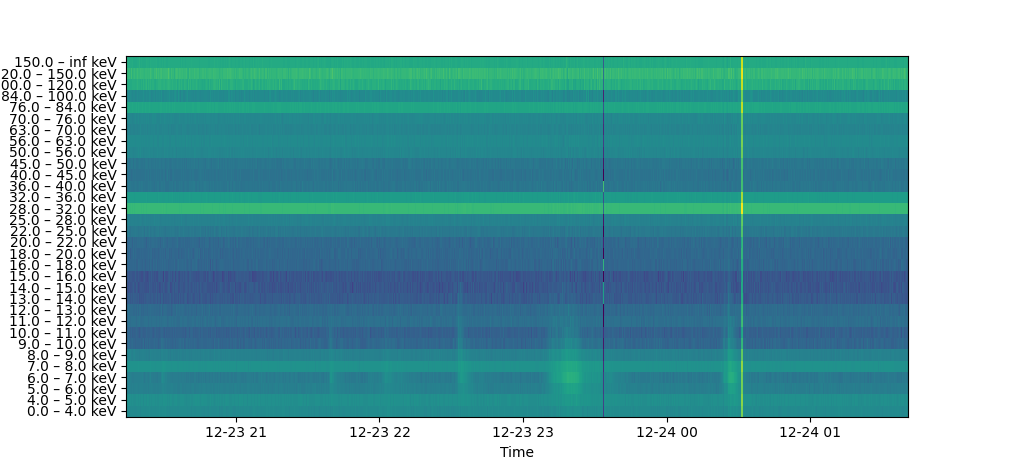

In [60]:
spec.peek()

In [53]:
plt.plot(spec.data['datetime'],spec.data['time_bins'])

# Search and download FITS files from STIX data center

Set download location